# Data import

In [434]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import seaborn as sns

In [435]:
sns.set_theme(style='whitegrid')
mpl.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format ='svg'

In [436]:
raw = pd.read_csv("http://hilpisch.com/tr_eikon_eod_data.csv", index_col=0, parse_dates=True)

In [437]:
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [438]:
symbol = 'EUR='

In [439]:
data = pd.DataFrame(raw[symbol])

In [440]:
data.head()

,EUR=
Date,
2010-01-01,1.4323
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318


In [441]:
data['Returns'] = np.log(data / data.shift(1))

In [442]:
data.dropna(inplace=True)

In [443]:
data['Direction'] = np.sign(data['Returns']).astype(int)

In [444]:
data.head()

,EUR=,Returns,Direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1


<Axes: >

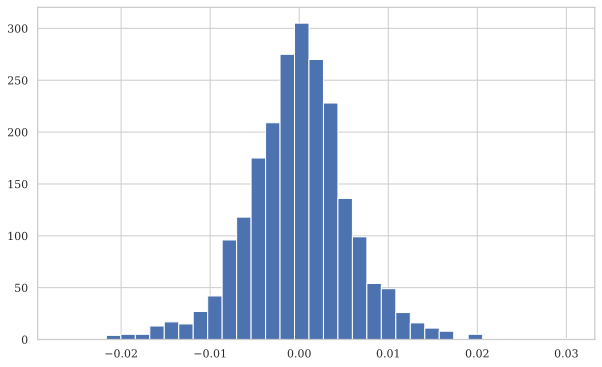

In [445]:
data['Returns'].hist(bins=35, figsize=(10,6))

In [446]:
def create_lags(data, lags):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        data[col] = data['Returns'].shift(1)
        cols.append(col)

In [447]:
create_lags(data, 2)

In [448]:
data.dropna(inplace=True)
data.head()

,EUR=,Returns,Direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,0.006125,0.006125
2010-01-06,1.4412,0.003058,1,-0.002988,-0.002988
2010-01-07,1.4318,-0.006544,-1,0.003058,0.003058
2010-01-08,1.4412,0.006544,1,-0.006544,-0.006544
2010-01-11,1.4513,0.006984,1,0.006544,0.006544


# Regression

In [449]:
from sklearn.linear_model import LinearRegression

In [450]:
model = LinearRegression()

In [451]:
data['pos_ols_1'] = model.fit(data[cols], data['Returns']).predict(data[cols])

In [452]:
data['pos_ols_2'] = model.fit(data[cols], data['Direction']).predict(data[cols])

In [453]:
data.head()

,EUR=,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-05,1.4368,-0.002988,-1,0.006125,0.006125,-0.000194,-0.029013
2010-01-06,1.4412,0.003058,1,-0.002988,-0.002988,-0.000049,0.024732
2010-01-07,1.4318,-0.006544,-1,0.003058,0.003058,-0.000145,-0.010923
2010-01-08,1.4412,0.006544,1,-0.006544,-0.006544,0.000008,0.045699
2010-01-11,1.4513,0.006984,1,0.006544,0.006544,-0.000200,-0.031481


In [454]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [455]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-05,-1,-1
2010-01-06,-1,1
2010-01-07,-1,-1
2010-01-08,1,1
2010-01-11,-1,-1


In [456]:
data['pos_ols_1'].value_counts()

pos_ols_1
-1    1918
 1     296
Name: count, dtype: int64

In [457]:
data['pos_ols_2'].value_counts()

pos_ols_2
 1    1327
-1     887
Name: count, dtype: int64

# Backtesting

In [458]:
data['starts_ols_1'] = data['pos_ols_1'] * data['Returns']

In [459]:
data['starts_ols_2'] = data['pos_ols_2'] * data['Returns']

In [460]:
data.head()

,EUR=,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2,starts_ols_1,starts_ols_2
Date,,,,,,,,,
2010-01-05,1.4368,-0.002988,-1,0.006125,0.006125,-1,-1,0.002988,0.002988
2010-01-06,1.4412,0.003058,1,-0.002988,-0.002988,-1,1,-0.003058,0.003058
2010-01-07,1.4318,-0.006544,-1,0.003058,0.003058,-1,-1,0.006544,0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,-0.006544,1,1,0.006544,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,0.006544,-1,-1,-0.006984,-0.006984


In [461]:
data[['Returns', 'starts_ols_1', 'starts_ols_2']].sum().apply(np.exp)

Returns         0.810700
starts_ols_1    0.982749
starts_ols_2    1.505684
dtype: float64

# K-Means Clustering

In [462]:
from sklearn.cluster import KMeans

In [463]:
model = KMeans(n_clusters=2, random_state=0)

In [464]:
model.fit(data[cols])

e:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [465]:
data['pos_clus'] = model.predict(data[cols])

In [466]:
data['pos_clus'].head()

Date
2010-01-05    1
2010-01-06    0
2010-01-07    1
2010-01-08    0
2010-01-11    1
Name: pos_clus, dtype: int32

In [467]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

In [468]:
plt.figure(figsize=(10,6))
plt.scatter(data[cols].iloc[:, 0], 
            data[cols].iloc[:, 1],
            c=data[]
            )

SyntaxError: invalid syntax (594435100.py, line 4)

In [469]:
data['start_clus'] = data['pos_clus'] * data['Returns']

In [ ]:
data[['Returns', 'start_clus']].cumsum().apply(np.exp)

Returns       0.810700
start_clus    1.294588
dtype: float64